<a href="https://colab.research.google.com/github/smci1000/Colab/blob/main/GrabStockData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

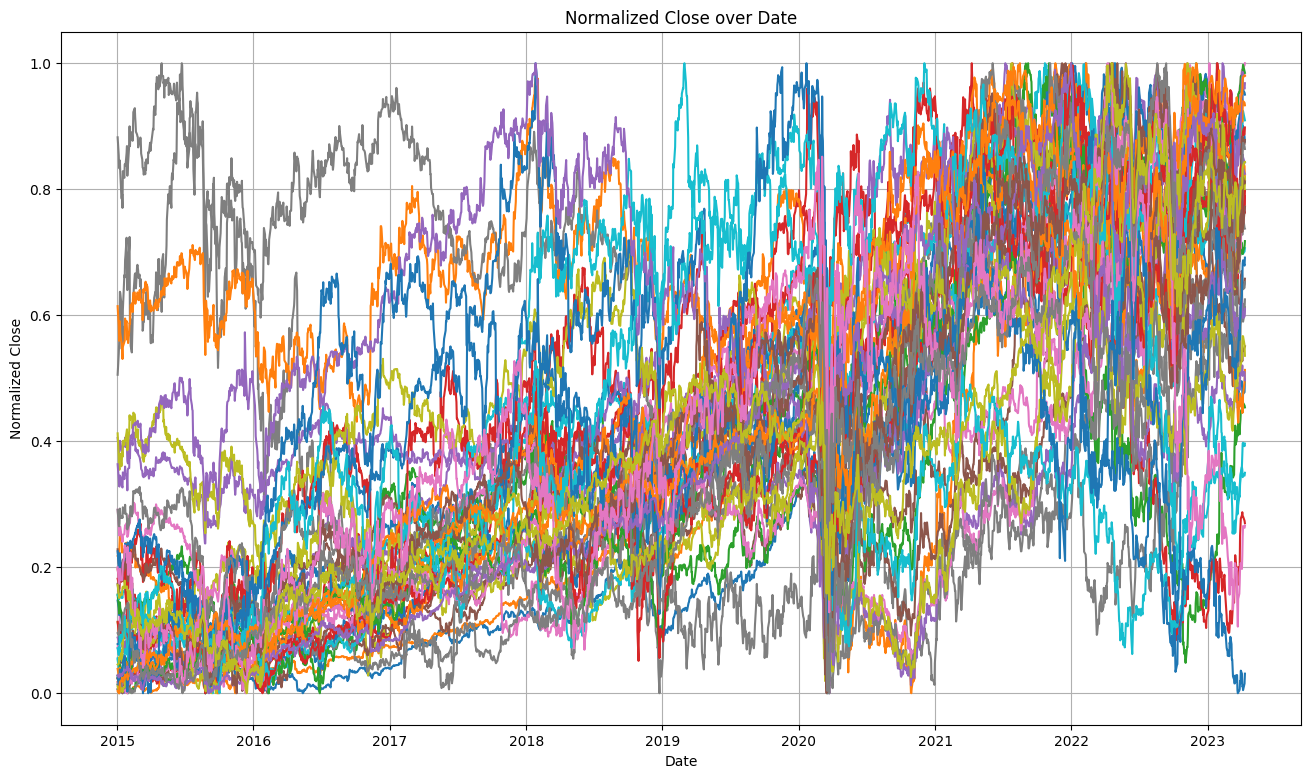

In [131]:
from datetime import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import random
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import yfinance as yf

def fetch_historical_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    historical_data = stock.history(start=start_date, end=end_date)
    return historical_data

top_sector_symbols =  '''
Technology:

Apple Inc. (AAPL)
Microsoft Corporation (MSFT)
Alphabet Inc. (GOOGL, GOOG)
Facebook, Inc. (META)
Intel Corporation (INTC)
Health Care:

Johnson & Johnson (JNJ)
Pfizer Inc. (PFE)
Merck & Co., Inc. (MRK)
Gilead Sciences, Inc. (GILD)
Amgen Inc. (AMGN)
Financials:

JPMorgan Chase & Co. (JPM)
Bank of America Corporation (BAC)
Wells Fargo & Company (WFC)
Goldman Sachs Group, Inc. (GS)
Visa Inc. (V)
Consumer Discretionary:

Amazon.com, Inc. (AMZN)
The Home Depot, Inc. (HD)
McDonald's Corporation (MCD)
NIKE, Inc. (NKE)
Starbucks Corporation (SBUX)
Consumer Staples:

The Procter & Gamble Company (PG)
The Coca-Cola Company (KO)
Walmart Inc. (WMT)
PepsiCo, Inc. (PEP)
Colgate-Palmolive Company (CL)
Energy:

Exxon Mobil Corporation (XOM)
Chevron Corporation (CVX)
ConocoPhillips (COP)
Schlumberger Limited (SLB)
EOG Resources, Inc. (EOG)
Industrials:

The Boeing Company (BA)
3M Company (MMM)
Honeywell International Inc. (HON)
United Technologies Corporation (UTX)
Caterpillar Inc. (CAT)
Materials:

E. I. du Pont de Nemours and Company (DD)
The Dow Chemical Company (DOW)
Monsanto Company (MON)
PPG Industries, Inc. (PPG)
Newmont Corporation (NEM)
Telecommunication Services:

Verizon Communications Inc. (VZ)
AT&T Inc. (T)
T-Mobile US, Inc. (TMUS)
CenturyLink, Inc. (CTL)
Frontier Communications Corporation (FTR)
Utilities:

NextEra Energy, Inc. (NEE)
Duke Energy Corporation (DUK)
Dominion Energy, Inc. (D)
Southern Company (SO)
Exelon Corporation (EXC)
'''

def do_fetch():
  raw_data = {}
  pattern = r'\((\w+)\)'
  words = re.findall(pattern, top_sector_symbols)
  for ticker in words:
    raw_data[ticker] = fetch_historical_stock_data(ticker, start_date, end_date)
  return raw_data

def parse_tickers_and_save():
  df = raw_data['AAPL']
  for k, v in raw_data.items():
    # Normalize the 'Close' values per k (symbol) and store in df
    key = '%snc' % k
    df[key] = v['Close'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

  # Cleaning
  df = df.drop(['Close', 'Volume', 'Open', 'High', 'Low', 'Dividends', 'Stock Splits'], axis=1)
  pickle.dump(df, open("save.p", "wb"))

start_date = "2015-01-01"
end_date = "2023-04-12"
#raw_data = do_fetch()
#parse_tickers_and_save()

data = pickle.load(open('save.p', 'rb'))

if True:
  # Plot the 'Close' values over the 'Date' column
  plt.figure(figsize=(16, 9))
  for c in data.columns:
    plt.plot(data.index, data[c])
  plt.xlabel('Date')
  plt.ylabel('Normalized Close')
  plt.title('Normalized Close over Date')
  plt.grid(True)
  plt.show()

In [139]:
df = pickle.load(open('save.p', 'rb'))

# Convert the dataset into input-output pairs for the LSTM
time_steps = 5
#time_steps = 64
X, y = [], []
for i in range(len(df) - time_steps):
    X.append(df.iloc[i:(i + time_steps)].values)
    y.append(df['AAPLnc'].iloc[i + time_steps])

print(len(X))
print(len(y))
print(pd.DataFrame(X[0]).describe())
raise

X = np.array(X)
y = np.array(y)

if True:
  # Split the dataset into training and testing sets
  #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.07, random_state=42)
else:
  #tlen = int(X.shape[0] * 0.8)
  tlen = int(X.shape[0] * 0.93)
  X_train = X[:tlen]
  X_test = X[tlen:]
  y_train = y[:tlen]
  y_test = y[tlen:]

  # Shuffle
  shuffle_indices = np.random.permutation(len(X_train))
  X_train = X_train[shuffle_indices]
  y_train = y_train[shuffle_indices]

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Create the LSTM model
input_size = 2
#hidden_size = 50
hidden_size = 64
num_layers = 1
output_size = 1
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Set the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the LSTM model
#num_epochs = 50
num_epochs = 256
loss_data = []
for epoch in tqdm(range(num_epochs), desc="Training"):
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train.view(-1, 1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_data.append(loss.item())

# Evaluate the model
y_pred_test = model(X_test)
test_loss = criterion(y_pred_test, y_test.view(-1, 1))
print(f"\nTest Loss: {test_loss.item()}")

# Plot training loss over the epochs
plt.figure()
plt.plot(loss_data)
plt.title('Training Loss over Epochs')
plt.show()


2077
2077
             0         1         2         3         4         5         6   \
count  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000   
mean   0.021591  0.017509  0.010301  0.176250  0.089739  0.034235  0.099008   
std    0.003343  0.002065  0.003527  0.009669  0.009534  0.010002  0.022616   
min    0.018715  0.015040  0.006815  0.161926  0.079036  0.025089  0.072226   
25%    0.018729  0.016701  0.006815  0.174230  0.082859  0.028249  0.080322   
50%    0.020824  0.016988  0.010191  0.175515  0.088330  0.029922  0.102037   
75%    0.023045  0.018220  0.013403  0.181759  0.096125  0.037916  0.114323   
max    0.026645  0.020598  0.014280  0.187818  0.102346  0.049999  0.126133   

             7         8         9   ...        39        40        41   42  \
count  5.000000  5.000000  5.000000  ...  5.000000  5.000000  5.000000  0.0   
mean   0.564595  0.101368  0.038799  ...  0.072763  0.023259  0.006404  NaN   
std    0.050069  0.011508  0.009345  ... 

RuntimeError: ignored